In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

seed = 0
random.seed(seed)
np.random.seed(seed)

## 택시 환경 소개

**택시 환경 공간**
- 5 x 5 행렬 위에 Red, Green, Yellow, Blue로 표기된 4가지 장소가 고정된 위치에 배치되어 있습니다.

~~~
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
~~~

<br>

**환경 초기화**
- 환경 시작시, 택시는 25개 위치 중에서 랜덤하게 배치됩니다. 
- 환경 시작시, 승객은 4가지 장소 또는 택시 안에 배치됩니다.
- 환경 시작시, 승객의 목적지가 4가지 장소 중에 한 곳으로 정해집니다.

<br>

**상태 공간**
- 환경을 상태는 (현재 택시가 있는 행, 현재 택시가 있는 열, 승객의 장소, 목적지)로 나타낼 수 있습니다.
- 사실 상태를 4차원 벡터로 나타내지 않고, 가능한 상태마다 각각 0부터 499까지의 숫자를 붙여 상태로 사용합니다.
- 가능한 모든 상태 $5 \times 5 \times 5 \times 4 = 500$가지입니다. 

<br>

**행동 공간**
- 가능한 행동의 개수는 6개이며, 각각 다음을 나타냅니다.
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

<br>

**보상**
- 목적지에서 승객을 하차 (drop off)시키면 +20의 보상을 받습니다.
- 잘못된 위치에서 승하차 행동을 취하면 -10의 보상을 받습니다.
- 다른 보상을 받지 않았다면, 매 스탭마다 -1을 보상을 받습니다.

<br>

더 자세한 정보가 궁금하시면, 아래 링크를 참조해주세요.
- https://www.gymlibrary.dev/environments/toy_text/taxi/


In [2]:
# 환경 만들기
env = gym.make('Taxi-v3')
env.seed(seed)

print("가능한 상태의 개수: ", env.observation_space)
print("가능한 행동의 개수: ", env.action_space)

가능한 상태의 개수:  Discrete(500)
가능한 행동의 개수:  Discrete(6)


## 환경과 상호작용 (interaction)하기

In [3]:
# 환경 초기화
s, done, score, t = env.reset(), False, 0, 0

# done이 True가 될 때까지 반복하여 환경과 상호작용
while not done:
    # 행동 선택 (이 코드에서는 임의의 행동을 취함)
    a = np.random.randint(0, 6)
    
    # 행동 취하고 (다음 상태, 보상, 종료 여부, 기타 정보) 관찰
    s_prime, r, done, info = env.step(a)
    
    # 누적 보상 계산하고, 다음 상태를 현재 상태로 바꿔준 후 타임스탭 종료
    t += 1
    score += r
    s = s_prime
    
print("에피소드 점수: ", score)
    

에피소드 점수:  -713


## Q-learning 구현
### 1. Q 테이블 정의하기
- Q 테이블의 $s$행 $a$열에는 $Q^{*}(s, a)$의 추정치가 저장되어 있습니다.

In [4]:
Qtable = np.zeros((500, 6))  # Q 테이블 만들기

### 2. 정책 구현하기
- $\epsilon$-greedy 정책은 주어진 상태 $s$에서
    - $\epsilon$의 확률로 임의의 행동을 취하고, 
    - $1 - \epsilon$의 확률로 $Q(s, a)$ 값이 가장 큰 행동 $a$를 취합니다.


In [5]:
def epsilon_greedy_policy(state, epsilon=0.1):
    action = np.random.randint(6)
    #########################################################
    # 다음 빈칸을 채워주세요.
    # 아래에서 `action` 변수를 수정해주지 않으면
    # 위 코드에 의해서 임의의 행동을 취합니다.
    # 힌트 1. np.random.rand(): 0과 1사이에서 임의의 수 뽑기
    # 힌트 2. np.argmax(array): array에서 가장 큰 값의 인덱스를 반환
    ########################################################
    if np.random.rand() < epsilon:
        action = np.random.randint(6)

    else:
        action = np.argmax(Qtable[state])
    ########################################################

    return action

### 3. Q-learning 구현 

Q learning의 Q 테이블 업데이트식은 다음과 같습니다.

$$Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right).$$

<br>

#### 학습에 이용될 매개변수들 정의하기
아래 3개의 값을 바꿔가면서 멘토보다 더 좋은 에이전트를 만들어보세요. 물론 알고리즘 자체를 바꿔봐도 괜찮습니다. 예를 들어, 
- 몇몇 위치에서는 일부 행동이 벽에 막혀서 아무런 위치 변화를 만들어내지 못합니다. 이를 고려해볼 수도 있겠죠? 
- 아니면 고정된 $\alpha$와 $\epsilon$을 사용하지 않아도 괜찮습니다.
- Q 테이블을 모두 꼭 0으로 초기화할 필요도 없습니다.
- `np.argmax`는 동일한 값에 대해서 가장 빠른 인덱스를 불러옵니다. 동일한 최대값 중에 랜덤하게 뽑는 것도 생각해볼 수 있습니다.

<br>

**멘토의 테스트 점수**
- 평균 에피소드 보상:  -74.35
- 평균 에피소드 길이:  86.95
- 공정한 점수 비교를 위해 코드가 완성되면 `Kernel` 탭의 `Restart and Run All`을 통해 코드를 모두 실행해주세요.


In [6]:
alpha = 0.01
gamma = 0.6
epsilon = 0.1

In [7]:
ts = []
scores = []
Qtable = np.zeros((500, 6))
for e in range(50000):

    # 환경 초기화
    s, done, score, t = env.reset(), False, 0, 0

    # done이 True가 될 때까지 반복하여 환경과 상호작용
    while not done:
        # epsilon greedy 정책을 따라 행동을 선택
        a = epsilon_greedy_policy(state=s, epsilon=epsilon)

        # 행동 취하고 (다음 상태, 보상, 종료 여부, 기타 정보) 관찰
        s_prime, r, done, info = env.step(a)

        #########################################################
        # 다음 빈칸을 채워주세요.
        ########################################################
        Qtable[s, a] = Qtable[s, a] + alpha * (r + (1 - done) * gamma * np.max(Qtable[s_prime]) - Qtable[s, a])
        ########################################################
        
        # 누적 보상 계산하고, 다음 상태를 현재 상태로 바꿔준 후 타임스탭 종료
        t += 1
        score += r
        s = s_prime

    if e % 1000 == 0:
        ts.append(t)
        scores.append(score)
        print(f"에피소드 {e:5}의 점수: {score:4}, 에피소드 길이: {t:3}")
    

에피소드     0의 점수: -533, 에피소드 길이: 200
에피소드  1000의 점수: -290, 에피소드 길이: 200
에피소드  2000의 점수:  -89, 에피소드 길이:  74
에피소드  3000의 점수: -245, 에피소드 길이: 200
에피소드  4000의 점수:  -35, 에피소드 길이:  38
에피소드  5000의 점수: -254, 에피소드 길이: 200
에피소드  6000의 점수:  -18, 에피소드 길이:  21
에피소드  7000의 점수: -167, 에피소드 길이: 152
에피소드  8000의 점수:   10, 에피소드 길이:  11
에피소드  9000의 점수:   13, 에피소드 길이:   8
에피소드 10000의 점수: -106, 에피소드 길이: 100
에피소드 11000의 점수:    8, 에피소드 길이:  13
에피소드 12000의 점수:  -18, 에피소드 길이:  21
에피소드 13000의 점수:  -18, 에피소드 길이:  21
에피소드 14000의 점수:  -23, 에피소드 길이:  26
에피소드 15000의 점수:    7, 에피소드 길이:  14
에피소드 16000의 점수:   12, 에피소드 길이:   9
에피소드 17000의 점수:   10, 에피소드 길이:  11
에피소드 18000의 점수:    5, 에피소드 길이:  16
에피소드 19000의 점수:    0, 에피소드 길이:  12
에피소드 20000의 점수:  -14, 에피소드 길이:  26
에피소드 21000의 점수:  -49, 에피소드 길이:  61
에피소드 22000의 점수:   -3, 에피소드 길이:  24
에피소드 23000의 점수:   -7, 에피소드 길이:  19
에피소드 24000의 점수:  -16, 에피소드 길이:  19
에피소드 25000의 점수:    7, 에피소드 길이:  14
에피소드 26000의 점수:  -40, 에피소드 길이:  61
에피소드 27000의 점수:   -7, 에피소드 길이:  19
에피소드 28000의 점수:    3

#### 학습 곡선 그리기

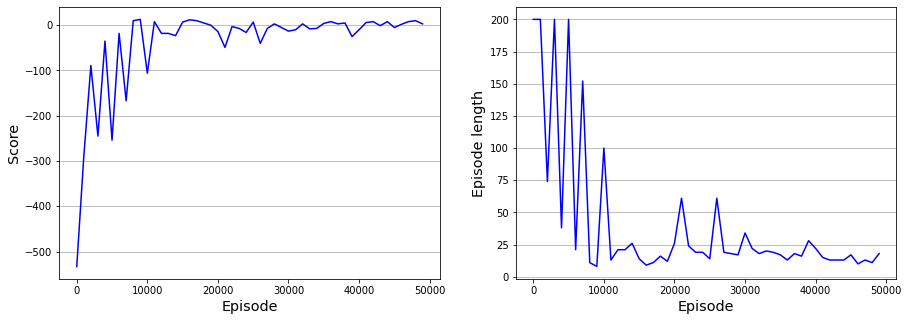

In [8]:
x = np.arange(0, 50000, 1000)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, scores, 'b-')
plt.xlabel("Episode", fontsize='x-large')
plt.ylabel("Score", fontsize='x-large')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.plot(x, ts, 'b-')
plt.xlabel("Episode", fontsize='x-large')
plt.ylabel("Episode length", fontsize='x-large')
plt.grid(axis='y')

plt.show()

#### 테스트

In [9]:
seed = 1000

np.random.seed(seed)
env = gym.make('Taxi-v3')
env.seed(seed)
ts = []
frames = []
scores = []
for e in range(20):
    # 환경 초기화
    s, done, score, t = env.reset(), False, 0, 0

    # done이 True가 될 때까지 반복하여 환경과 상호작용
    while not done:
        frames.append(env.render('ansi'))
        
        # epsilon greedy 정책을 따라 행동을 선택
        a = epsilon_greedy_policy(state=s, epsilon=0.00)

        # 행동 취하고 (다음 상태, 보상, 종료 여부, 기타 정보) 관찰
        s_prime, r, done, info = env.step(a)

        # 누적 보상 계산하고, 다음 상태를 현재 상태로 바꿔준 후 타임스탭 종료
        t += 1
        score += r
        s = s_prime
    
    ts.append(t)
    scores.append(score)

print("평균 에피소드 보상: ", np.mean(scores))
print("평균 에피소드 길이: ", np.mean(ts))

평균 에피소드 보상:  -74.35
평균 에피소드 길이:  86.95


아래는 테스트 때 나온 에이전트의 움직임입니다. 에이전트가 어떤 문제를 겪고 있나요?

In [10]:
import time
from IPython.display import clear_output

for s in frames:
    clear_output()
    print(s)
    time.sleep(0.05)
    

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

